In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns


In [2]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    # Ensure month and lease_commence_date are datetime
    df = clean_hdb_df.copy()

    # Drop rows with missing or invalid price
    df = df[df["resale_price"].notnull() & (df["resale_price"] > 0)]

    #date type
    df["month"] = pd.to_datetime(df["month"])
    df["lease_commence_date"] = pd.to_datetime(df["lease_commence_date"], errors='coerce')

    # Features
    feature_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_year": df["month"].dt.year,
        "town": df["town"],
        "flat_type": df["flat_type"],
        "flat_age": ((df["month"] - df["lease_commence_date"]).dt.days / 365.25).clip(lower=0),
    })

    # Targets (log-transform)
    target_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_price": df["resale_price"]
    })

    # Split into past and future
    past_mask = feature_df["resale_year"] <= year_cutoff
    future_mask = feature_df["resale_year"] > year_cutoff

    past_feature_df = feature_df[past_mask].copy()
    future_feature_df = feature_df[future_mask].copy()

    past_target_df = target_df[past_mask].copy()
    future_target_df = target_df[future_mask].copy()

    return past_feature_df, past_target_df, future_feature_df, future_target_df


In [3]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

In [4]:
# copy
df = clean_hdb_df1.copy()

In [5]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(df, year_cutoff=2013)

Test Train split on past data

In [6]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    past_feature_df, past_target_df, test_size=0.2, random_state=42
)


# One-hot encode categoricals, scale numerics

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [8]:
def preprocess_features_pipeline(feature_df, numeric_features=None, categorical_features=None, preprocessor=None, fit=True):
    df = feature_df.copy()
    if "transaction_id" in df.columns:
        df = df.drop(columns=["transaction_id"])

    if numeric_features is None:
        numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ])

    if fit:
        X_processed = preprocessor.fit_transform(df)
    else:
        X_processed = preprocessor.transform(df)

    return X_processed, preprocessor


In [9]:
categorical_cols = ["town", "flat_type"]
numeric_cols = ["resale_year", "flat_age"]

In [10]:
X_train, preprocessor = preprocess_features_pipeline(X_train_df, numeric_cols, categorical_cols, fit=True)
X_test, _ = preprocess_features_pipeline(X_test_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)
X_future, _ = preprocess_features_pipeline(future_feature_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)


# Model

Random Forest Model (can be slower than XGBoost, but not significant)

In [14]:
#from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=500, # number of trees, 100–1000 depending on dataset size.
    max_depth=10, #None,    # grow trees fully; or set e.g., 10–20, limit to prevent overfitting if dataset is small.
    min_samples_split=2, # min samples to split a node
    min_samples_leaf=1, # min samples per leaf, increase to smooth predictions.
    n_jobs=-1,    # use all cores
    random_state=42,
    
)

In [15]:
# convert df to np array
y_train = y_train_df["resale_price"].values.astype(float)

Model Training

In [16]:


rf_model.fit(X_train,y_train)



,n_estimators,500
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Model Testing

In [17]:
y_test_predict=rf_model.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
y_test = y_test_df["resale_price"].values.astype(float)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
mape = np.mean(np.abs((y_test - y_test_predict) / y_test)) * 100
r2 = r2_score(y_test, y_test_predict)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {r2:.4f}")

if r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 42459.77
Test Mean Absolute Percentage Error: 12.19%
Test R^2 (Coefficient of Determination): 0.8965


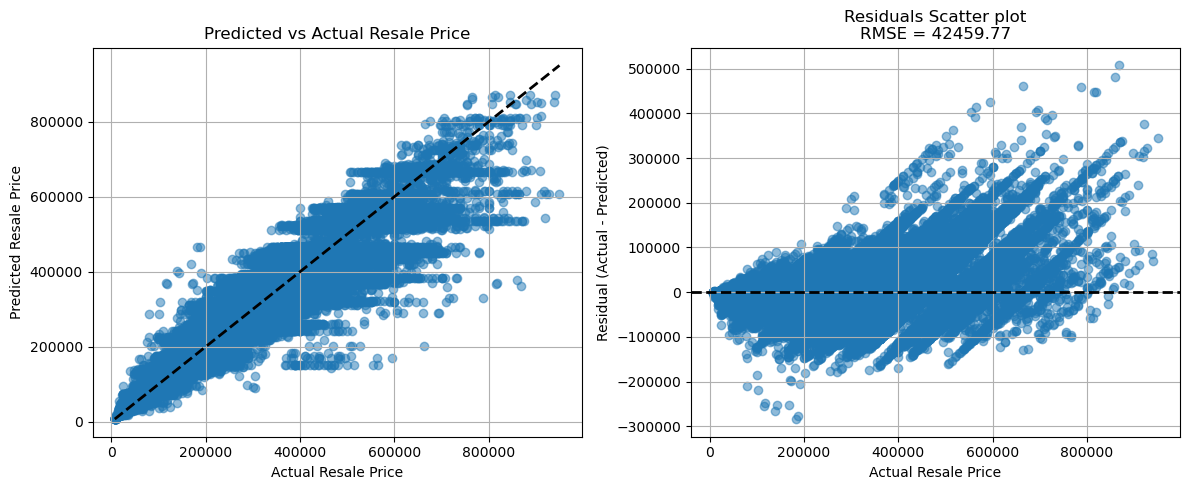

In [19]:
# Scatter plot: predicted vs actual resale prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.grid(True)

# RMSE as residual scatter plot
residuals = y_test - y_test_predict
rmse_values = rmse # Just absolute residuals (RMSE scalar but per-point residual = abs error)
#mape_values = np.abs((y_test - y_test_predict) / y_test) * 100

plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
#plt.ylabel('Percentage Residual (Actual - Predicted)')
plt.title(f'Residuals Scatter plot\nRMSE = {rmse:.2f}')
plt.grid(True)

plt.tight_layout()
plt.show()




Predicting with new data

In [20]:
example_df = pd.DataFrame([{ "transaction_id":0,"flat_age": 25, "flat_type": "4 ROOM", "town": "BEDOK", "resale_year": 2014 }])


In [21]:
example_df

,transaction_id,flat_age,flat_type,town,resale_year
0,0,25,4 ROOM,BEDOK,2014


In [22]:
X_example, _ = preprocess_features_pipeline(
    example_df,
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    preprocessor=preprocessor,  # preprocessor fitted during training
    fit=False   
)

In [23]:
pred_price = rf_model.predict(X_example)
print(f"Predicted resale price for example flat: SGD {pred_price}")

Predicted resale price for example flat: SGD [458397.35819105]


In [24]:
def predict_resale_price(model, actual_df, flat_type, town, flat_age, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : statsmodels results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
            'transaction_id': [0],  # Dummy ID
            'resale_year': [resale_year],
            'town': [town],
            'flat_age': [flat_age],
            'flat_type': [flat_type]
            })
    print(input_df.shape)
    
    X_input, _ = preprocess_features_pipeline(input_df,
            numeric_features=numeric_cols,
            categorical_features=categorical_cols,
            preprocessor=preprocessor,  # preprocessor fitted during training
            fit=False   
            )
  
    predicted_price = model.predict(X_input)

    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 2) &
        (actual_df['flat_age'] <= flat_age + 2) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${similar_flats['resale_price'].mean():,.2f}")
        print(f"  Price Range: ${similar_flats['resale_price'].min():,.2f} - ${similar_flats['resale_price'].max():,.2f}")
        print(f"  Median: ${similar_flats['resale_price'].median():,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [25]:
predicted_price, similar_flats = predict_resale_price(
    model=rf_model,
    flat_type='4 ROOM',
    town='BEDOK',
    flat_age=25,
    resale_year=2014,
    actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f}")

(1, 5)

Similar Flats Found: 4
  Average Actual Price: $452,472.00
  Price Range: $400,000.00 - $598,000.00
  Median: $405,944.00

Predicted Resale Price: 458397.36
